# Lab 7 - hyperparameter tuning job and compare the metrics

## Overview

This lab is a continuation of the guided labs of ML Implementation Pipeline. 

In this lab, you will create a hyperparameter tuning job to tune the model that you created previously. You will then compare the metrics of the two models.


## Introduction to the business scenario

You work for a healthcare provider, and want to improve the detection of abnormalities in orthopedic patients. 

You are tasked with solving this problem by using machine learning (ML). You have access to a dataset that contains six biomechanical features and a target of *normal* or *abnormal*. You can use this dataset to train an ML model to predict if a patient will have an abnormality.


## About this dataset

This biomedical dataset was built by Dr. Henrique da Mota during a medical residence period in the Group of Applied Research in Orthopaedics (GARO) of the Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, France. The data has been organized in two different, but related, classification tasks. 

The first task consists in classifying patients as belonging to one of three categories: 

- *Normal* (100 patients)
- *Disk Hernia* (60 patients)
- *Spondylolisthesis* (150 patients)

For the second task, the categories *Disk Hernia* and *Spondylolisthesis* were merged into a single category that is labeled as *abnormal*. Thus, the second task consists in classifying patients as belonging to one of two categories: *Normal* (100 patients) or *Abnormal* (210 patients).


## Attribute information

Each patient is represented in the dataset by six biomechanical attributes that are derived from the shape and orientation of the pelvis and lumbar spine (in this order): 

- Pelvic incidence
- Pelvic tilt
- Lumbar lordosis angle
- Sacral slope
- Pelvic radius
- Grade of spondylolisthesis

The following convention is used for the class labels: 
- DH (Disk Hernia)
- Spondylolisthesis (SL)
- Normal (NO) 
- Abnormal (AB)


For more information about this dataset, see the [Vertebral Column dataset webpage](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column).


## Dataset attributions

This dataset was obtained from:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository (http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.


#### Lab setup

Because this solution is split across several labs in the module, you run the following cells so that you can load the data and train the model to be deployed.  **Note:** The setup can take up to 5 minutes to complete.

###  Importing the data, and training, testing and validating the model 

By running the following cells, the data will be imported, and the model will be trained, tested and validated and ready for use. **Note:** The following cells represent the key steps in the previous labs.
In order to tune the model it must be ready, then you can tweak the mdoel with hyperparameters later  strating from step 1.

In [8]:
import pandas as pd
import requests
import zipfile
import io
from scipy.io import arff
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import warnings
import os
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
import xgboost as xgb

**Note:** Observe the code and how it processes, this will help you to better understand what is going on in the background.  Keep in mind that this cell completes all the steps you did in previous labs in this module including:
 - Importing the data
 - Splitting the data into training, test and validation datasets
 - Training, testing and validating the model with the datasets

In [9]:
%%time
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()
data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])
class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])
model = XGBClassifier(objective='binary:logistic', eval_metric='auc', num_round=42)
print(model.fit(train.drop(['class'], axis = 1).values, train['class'].values))
print("Training Completed")

[16:30:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_round" } are not used.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              num_round=42, predictor=None, ...)
Training Completed
Wall time: 397 ms


Parameters:
(1) **Objective**, Value type : string. Specifies the learning task and the corresponding learning objective.
Examples: reg:logistic, multi:softmax, reg:squarederror. 
binary:logistic means logistic regression for binary classification, returns predicted probability.

(2) **eval_matric**  Value type : string. Evaluation metrics for validation data.
A default metric is assigned according to the objective:  rmse: for regression, error: for classification, map: for ranking logistic. 
auc: ROC area under curve (When used with binary classification, the objective should be binary:logistic that work on probability.

(3) **Num_round** Value type : Integer. The number of rounds to run the training.

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score


    
def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    
    
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100
    
    
    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    ax2 = plt.gca().twinx()
    # ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
    # ax2.set_ylabel('Threshold', color='r')
    valid_thresholds = thresholds[np.logical_and(~np.isnan(thresholds), ~np.isinf(thresholds))]
    ax2.set_ylim([valid_thresholds[-1], valid_thresholds[0]]) if valid_thresholds.size > 0 else None
    
    ax2.set_xlim([fpr[0], fpr[-1]])
    
    plt.show()
    


## Step 1: Getting model statistics

Before you tune the model, re-familiarize yourself with the current model's metrics.

The setup performed a batch prediction.

In [20]:
batch_X = test.iloc[:,1:];
predicted_probabilities = model.predict_proba(batch_X)
target_predicted = pd.DataFrame(predicted_probabilities[:, 1], columns=['class'])
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test_labels = test.iloc[:,0]

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


Plot the confusion matrix and the receiver operating characteristic (ROC) curve for the original model.


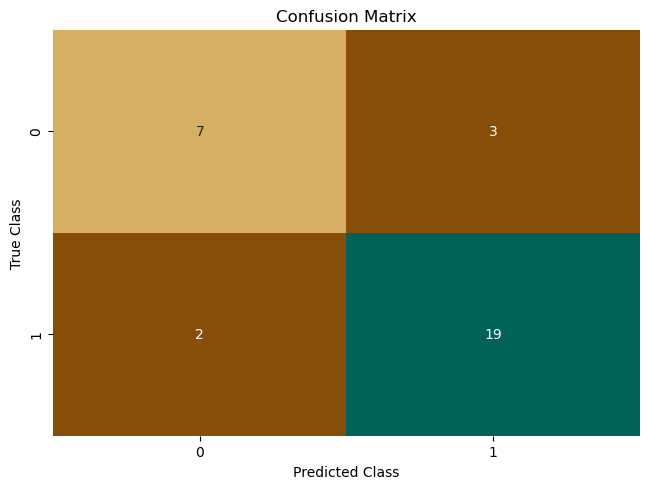

In [21]:
plot_confusion_matrix(test_labels, target_predicted_binary)

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%
Validation AUC 0.8023809523809523


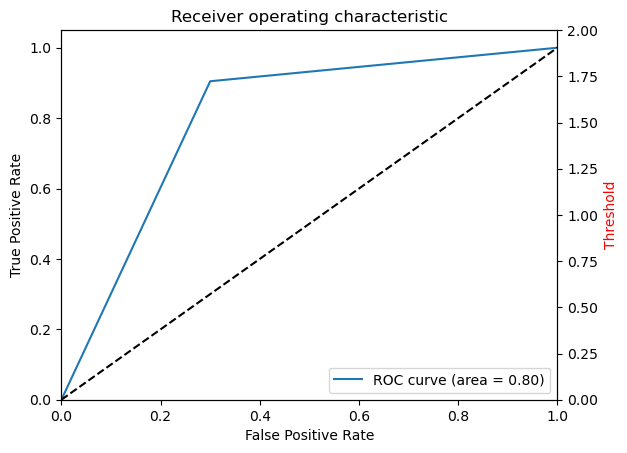

In [12]:
plot_roc(test_labels, target_predicted_binary)

This plot gives you a starting point. Make a note of the *Validation area under the curve (AUC)*. You will use it later to check your tuned model to see if it's better. 

## Step 2: Creating a hyperparameter tuning job

A hyperparameter tuning job can take some seconds to multiple hours to complete, depending on the value ranges that you provide. 

To simplify this task, the parameters used in this step are a subset of the recommended ranges. They were tuned to give good results in this lab, without taking multiple hours to complete.

For more information about the parameters to tune for XGBoost, see [Tune an XGBoost Model] https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [22]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# Define your XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='error@.40',
                              objective='binary:logistic')

# Define hyperparameter ranges
hyperparameter_ranges = {'alpha': [i for i in range(0, 101)],
                         'min_child_weight': [i for i in range(1, 6)],
                         'subsample': [i / 10 for i in range(5, 11)],
                         'eta': [i / 10 for i in range(1, 4)]}

search = RandomizedSearchCV(estimator=xgb_model,
                            param_distributions=hyperparameter_ranges,
                            scoring='neg_mean_squared_error',
                            n_iter=10,  # Number of parameter settings that are sampled
                            cv=5,       # Number of folds for cross-validation
                            verbose=1,
                            n_jobs=1)  # Use all available cores

search.fit(train.drop(['class'], axis = 1).values, train['class'].values)
best_params = search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1.41 s


In [23]:
best_params

{'subsample': 0.5, 'min_child_weight': 5, 'eta': 0.2, 'alpha': 18}

First, you will create the model that you want to tune.

```
xgb_model = xgb.XGBClassifier(eval_metric='error@.40',
                              objective='binary:logistic')
```                        

Notice that the *eval_metric* of the model was changed to *error@.40*, with a goal of minimizing that value. 

**error** is the binary classification error rate. It's calculated as *#(wrong cases)/#(all cases)*. For predictions, the evaluation will consider the instances that have a prediction value larger than 0.4 to be positive instances, and the others as negative instances.

Next, you must specify the hyperparameters that you want to tune, in addition to the ranges that you must select for each parameter.

The hyperparameters that have the largest effect on XGBoost objective metrics are: 

- **alpha**             ( L1 regularization term on weights. Increasing this value makes models more conservative.
- **min_child_weight**     ( minimum sum of instance weight needed in a child.)
- **subsample**  (Subsample ratio of the training instance. Setting it to 0.5 means that XGBoost randomly collects half of the data instances to grow trees. This prevents overfitting.)
- **eta**    (Learning rate : Value type: float,  Step size shrinkage used in updates to prevent overfitting. )


For this lab, you will use a *subset* of values. These values were obtained by running the tuning job with the full range, then minimizing the range so that you can use fewer iterations to get better performance. Though this practice isn't strictly realistic, it prevents you from waiting several hours in this lab for the tuning job to complete.

```
hyperparameter_ranges = {'alpha': [i for i in range(0, 101)],
                         'min_child_weight': [i for i in range(1, 6)],
                         'subsample': [i / 10 for i in range(5, 11)],
                         'eta': [i / 10 for i in range(1, 4)]}
```


You must specify how you are rating the model. You could use several different objective metrics, a subset of which applies to a binary classifcation problem. Because the evaluation metric is **error**, you set the objective to *error*.


Finally, you run the tuning job.

**Random search cross-validation** is a technique that searches for the optimal hyperparameters of a model by evaluating the model's performance on random combinations of hyperparameter values. The idea is to define a set of hyperparameters and a range of values for each hyperparameter, and then randomly sample values from these ranges to create different combinations of hyperparameters. This process is repeated a specified number of times, and the best combination of hyperparameters that produces the best performance on a validation set is selected.



```
# Define the search strategy, GridSearchCV for exhaustive search or RandomizedSearchCV for random search
search = RandomizedSearchCV(estimator=xgb_model,
                            param_distributions=hyperparameter_ranges,
                            scoring='neg_mean_squared_error',
                            n_iter=10,  # Number of parameter settings that are sampled
                            cv=5,       # Number of folds for cross-validation
                            verbose=1,
                            n_jobs=-1)  # Use all available cores

search.fit(train.drop(['class'], axis = 1).values, train['class'].values)
```



## Step 3: Investigating the Best Parameters tuning results

You can examine the metrics for the data.


In [24]:
# Retrieve the results of RandomizedSearchCV
cv_results = pd.DataFrame(search.cv_results_)

# Sort the results by mean_test_score (or other relevant metric)
cv_results.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Display the top 20 models
top_models = cv_results.head(20)
print(top_models[['params', 'mean_test_score']])

# Get the best hyperparameters
best_params = search.best_params_
print("Best Hyperparameters:", best_params)

# Create an XGBoost model with the best hyperparameters
best_xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='error', **best_params)

# Train the model with the best hyperparameters
best_xgb_model.fit(train.drop(['class'], axis = 1).values, train['class'].values)


                                              params  mean_test_score
4  {'subsample': 0.5, 'min_child_weight': 5, 'eta...        -0.237959
7  {'subsample': 0.6, 'min_child_weight': 1, 'eta...        -0.250122
2  {'subsample': 0.6, 'min_child_weight': 3, 'eta...        -0.258122
9  {'subsample': 0.8, 'min_child_weight': 4, 'eta...        -0.262041
0  {'subsample': 0.7, 'min_child_weight': 2, 'eta...        -0.265878
1  {'subsample': 0.8, 'min_child_weight': 1, 'eta...        -0.677388
3  {'subsample': 0.9, 'min_child_weight': 3, 'eta...        -0.677388
5  {'subsample': 0.8, 'min_child_weight': 5, 'eta...        -0.677388
6  {'subsample': 0.7, 'min_child_weight': 1, 'eta...        -0.677388
8  {'subsample': 0.5, 'min_child_weight': 2, 'eta...        -0.677388
Best Hyperparameters: {'subsample': 0.5, 'min_child_weight': 5, 'eta': 0.2, 'alpha': 18}


XGBClassifier(alpha=18, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric='error',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Get the predicted target and the test labels of the model.

In [25]:
batch_X = test.iloc[:,1:];
predicted_probabilities = best_xgb_model.predict_proba(batch_X)
target_predicted = pd.DataFrame(predicted_probabilities[:, 1], columns=['class'])
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

Plot a confusion matrix for your `best_target_predicted` and `test_labels`.

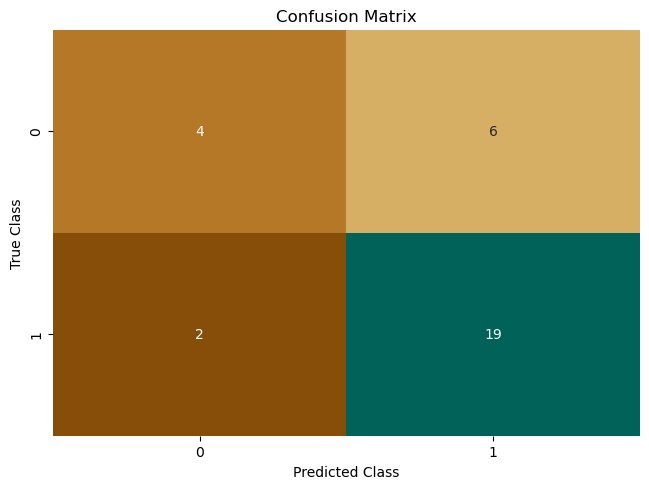

In [26]:
plot_confusion_matrix(test_labels, best_target_predicted_binary)

Plot the ROC chart.

Sensitivity or TPR: 95.23809523809523%
Specificity or TNR: 50.0%
Precision: 80.0%
Negative Predictive Value: 83.33333333333334%
False Positive Rate: 50.0%
False Negative Rate: 4.761904761904762%
False Discovery Rate: 20.0%
Accuracy: 80.64516129032258%
Validation AUC 0.7261904761904762


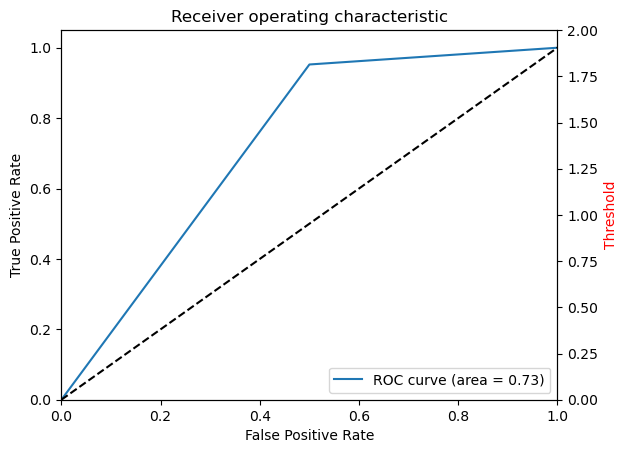

In [18]:
plot_roc(test_labels, best_target_predicted_binary)

**Question:** How do these results differ from the original? Are these results better or worse? 

You might not always see an improvement. There are a few reasons for this result:

- The model might already be good from the initial pass (what counts as *good* is subjective).
- You don't have a large amount of data to train with.
- You are using a *subset* of the hyperparameter tuning ranges to save time in this lab.

Increasing the hyperparameter ranges (as recommended by the documentation) and running different random search will typically improve the model. However, this process will take few minutes to complete.

### Congratulations!

You have completed this lab. 

